## Dictionary Learning Examples

In [1]:
import numpy as np
from pursuit import pursuit
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from scipy.fftpack import idctn

from scipy.misc import face, imresize
import matplotlib.pyplot as plt
%matplotlib inline


def get_reconstruction_error(data, dictionary, coeffs):
    return np.mean(np.sum((data - coeffs @ dictionary) ** 2, axis=-1))


def recover_coefficients_with_pursuit(data, dictionary, num_nonzeros, pursuit_type):
    return np.stack([pursuit(dictionary.T, data[i], num_nonzeros, pursuit_type=pursuit_type)[2] for i in range(data.shape[0])])

### MOD algorithm (method of optimal directons)

MOD algorithm alternates solving least squares problem for $A$ and pursuit algorithm for finding $X$.

In [2]:
def learn_dictionary_mod(Y, dictionary_size, pursuit_type='omp', eps=1e-3, max_iter=20, init_dictionary=None, verbose=False):
    if init_dictionary is None:
        A = np.random.randn(dictionary_size, Y.shape[1])
    else:
        assert dictionary_size == init_dictionary.shape[0]
        assert init_dictionary.shape[1] == Y.shape[1]
        A = init_dictionary
        
    X = recover_coefficients_with_pursuit(Y, A, k=1)
    reconstruction_errors = [get_reconstruction_error(Y, A, X)]
    
    while reconstruction_errors[-1] > eps and k < max_iter:
        if verbose:
            print('iteration', k, 'reconstruction error =', np.round(reconstruction_errors[-1], 4))
            print('average cardinality', (np.abs(X) > 1e-16).sum(axis=-1).mean())
        k += 1
        # solve least squares problem to find new dictionary
        A = np.linalg.pinv(X.T @ X).T @ X.T @ Y
        # update representation coefficients using pursuit
        X = recover_coefficients_with_pursuit(Y, A, k, pursuit_type=pursuit_type)
        reconstruction_errors.append(get_reconstruction_error(Y, A, X))
        
    return A, X, reconstruction_errors

## Setting up data and dictionary

As initial dictionary we will use 2D DCT transform coefficients.

In [3]:
def make_idct_coeffs(size):
    coeffs = []
    for i in range(size):
        for j in range(size):
            y = np.zeros((size, size))
            y[i,j] = 1
            coeffs.append(idctn(y, shape=(size,size)).reshape(size ** 2))
    return np.stack(coeffs)

idct_coeffs = make_idct_coeffs(8)

### Load image

In [4]:
img = imresize(face(gray=True), size=(384, 512))
img = (img / 127.5) - 1 

/home/kuba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


(384, 512)

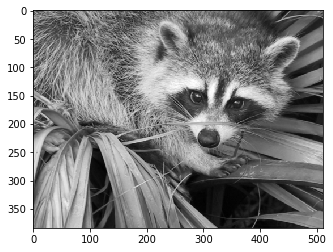

In [5]:
plt.imshow(img, cmap='gray')
img.shape

In [6]:
image_patches = extract_patches_2d(img, (8, 8)).reshape(-1, 64)
image_patches.shape

(190385, 64)

In [7]:
train_image_patches = image_patches[::10]
train_image_patches.shape

(19039, 64)

In [8]:
%%time

A, X, reconstruction_errors = learn_dictionary_mod(train_image_patches, 64, init_dictionary=idct_coeffs, verbose=True)

iteration 1 reconstruction error = 8.7692
average cardinality 1.0
iteration 2 reconstruction error = 1.6547
average cardinality 1.9998949524659908
iteration 3 reconstruction error = 2.1773
average cardinality 3.0
iteration 4 reconstruction error = 1.2156
average cardinality 4.0
iteration 5 reconstruction error = 0.7311
average cardinality 5.0
iteration 6 reconstruction error = 0.5821
average cardinality 6.0
iteration 7 reconstruction error = 0.4862
average cardinality 7.0
iteration 8 reconstruction error = 0.4082
average cardinality 8.0
iteration 9 reconstruction error = 0.3492
average cardinality 9.0
iteration 10 reconstruction error = 0.3046
average cardinality 10.0
iteration 11 reconstruction error = 0.269
average cardinality 11.0
iteration 12 reconstruction error = 0.2408
average cardinality 12.0
iteration 13 reconstruction error = 0.2181
average cardinality 13.0
iteration 14 reconstruction error = 0.199
average cardinality 14.0
iteration 15 reconstruction error = 0.1821
average ca

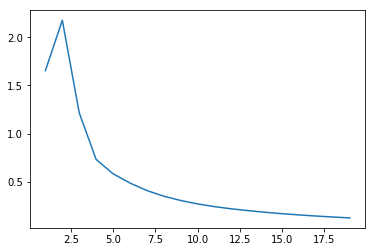

In [9]:
plt.plot(np.arange(1, 20), reconstruction_errors[1:])

In [10]:
A_patches = A.reshape(64, 8, 8)

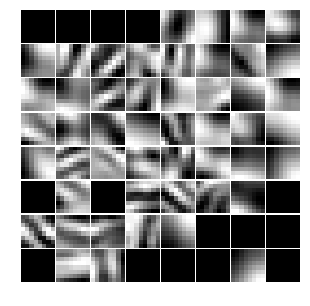

In [12]:
max_rows = 8
max_cols = 8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(5,5))

for idx, image in enumerate(A_patches):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")

plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()